# **Loss Function: Constellation vs N Pairs vs Triplet**

## **Importação de todas as bibliotecas utilizadas no notebook**

In [19]:
import os
import numpy as np
import cv2
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from IPython.display import Image
from collections import Counter
import skimage.io as io

import tensorflow as tf

from tensorflow import keras
from keras import applications
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.preprocessing.image import img_to_array, ImageDataGenerator

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model, normalize

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people, make_classification, load_files
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Allow memory growth for the GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.set_visible_devices([], 'GPU')

## **Banco de dados**

Atualmente, o código trabalha com os bancos de dados LFW e Olivetti, ambos importados pelo Keras.

Ao trocar o indice na função LoadDataset (0: LFW, 1: Olivetti), o banco de dados é carregado e o código consegue se adaptar independente do banco escolhido.

In [20]:
IMG_SHAPE = (224,224,3)

# Carrega o banco de dados Labeled Faces in the Wild (https://scikit-learn.org/0.16/datasets/labeled_faces.html)
def lfw():
    return fetch_lfw_people(min_faces_per_person=10), "lfw"

# Carrega o banco de dados Olivetti Faces (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)
def olivetti():
    return fetch_olivetti_faces(shuffle=True), "olivetti"

def LoadDataset(indice=0):
    dataset = databases.get(indice)
    return dataset()

databases = { 0: lfw, 1: olivetti }

def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig = plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,:])
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

# Ao redimensionar, precisei converter de escala de cinza para RGB
def resize_images_dataset(data,num_samples,new_shape):
    big_data = np.zeros((num_samples,) + new_shape, dtype = 'float32')
    for i,img in enumerate(data[0:num_samples,:,:]):
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, new_shape[0:2])
        norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        big_data[i,:,:,:] = img_to_array(norm_image)
    return big_data

def normalize_dataset(data,num_samples):
    big_data = np.zeros(data.shape, dtype = 'float32')
    for i,img in enumerate(data[0:num_samples,:,:]):
        norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        big_data[i,:,:,:] = img_to_array(norm_image)
    return big_data

def fill_datasets(images, labels, n_classes):
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)

    dataset_train = []
    dataset_test = []
    for n in range(n_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx] == n])
        dataset_train.append(images_class_n)
            
        images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
        dataset_test.append(images_class_n)

    return dataset_train, dataset_test, x_train, x_test, y_train, y_test


### **Labeled Faces in the Wild**

O conjunto de dados contém mais de 13.000 imagens de rostos coletados da web. Cada rosto foi etiquetado com o nome da pessoa retratada. 1.680 das pessoas retratadas têm duas ou mais fotos distintas no conjunto de dados.

<img src="https://i.ibb.co/nbRtRrr/LFW.png"></img>

### **Olivetti Faces**

O banco possui 400 imagens, entre os anos de 1992 e 1994, sendo 10 exemplos para cada um dos 40 individuos do AT&T Laboratories Cambridge.

<a href="https://ibb.co/FDszJRw"><img src="https://i.ibb.co/2k8dPGt/olivetti.png" alt="olivetti" border="0"></a>

### **Importação do Banco Escolhido**

Como os bancos aqui trabalhados possuem dimensões de imagens diferentes do que se espera trabalhar (224,224,3), as imagens são redimensionadas, normalizadas e convertidas para 3 canais (RGB).

O dataset é dividido em 70% das imagens para treinamento e 30% para teste.

<ipython-input-20-7e39c9dbbea5>:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  subplot = fig.add_subplot(nbligne,min(N,20),m+1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

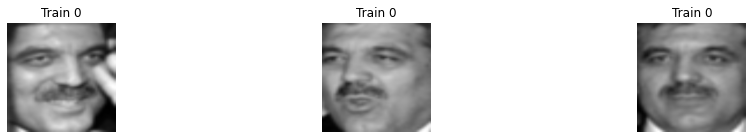

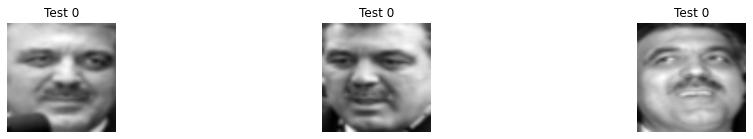

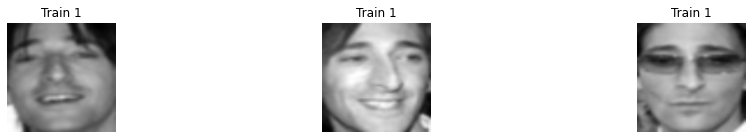

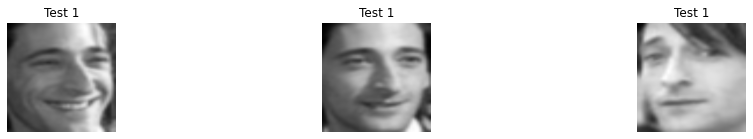

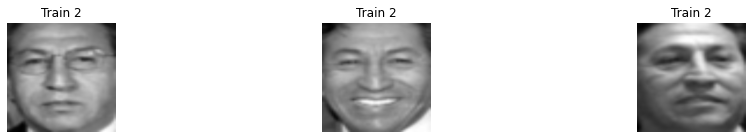

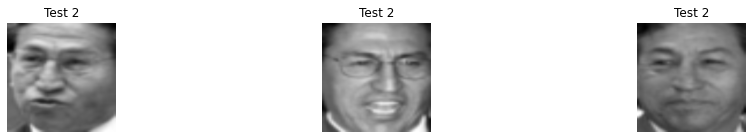

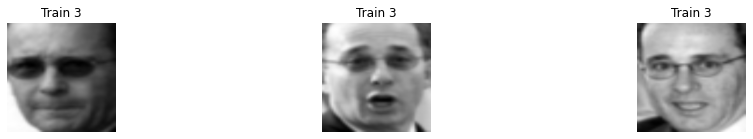

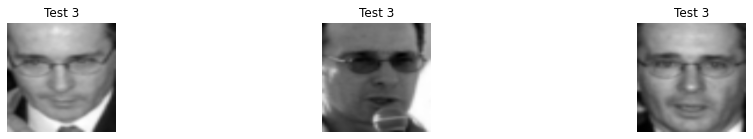

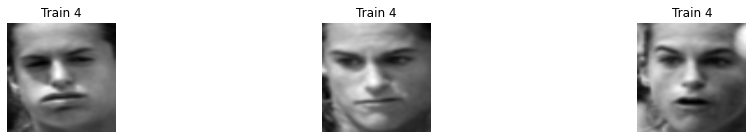

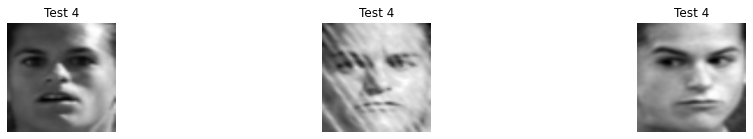

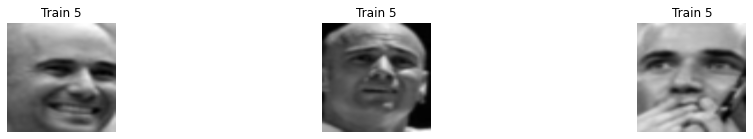

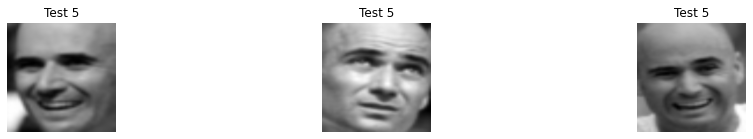

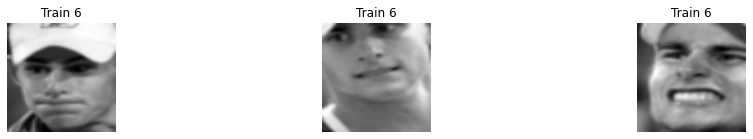

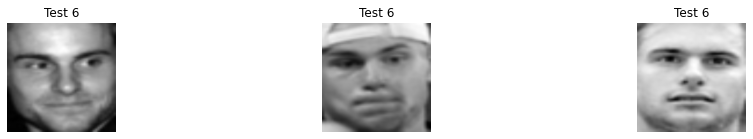

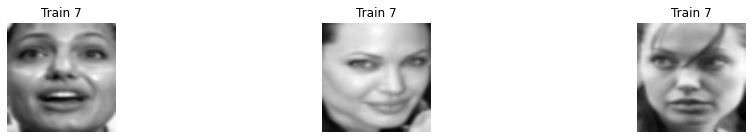

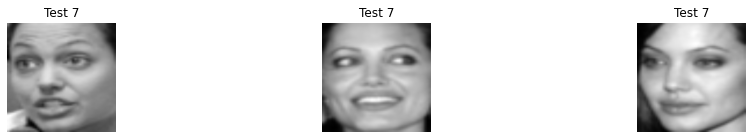

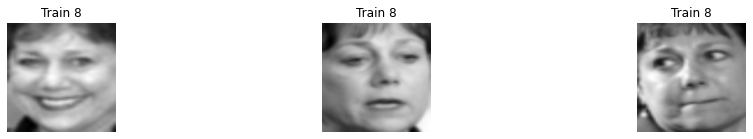

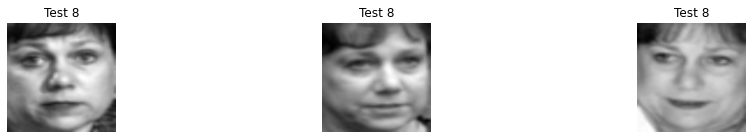

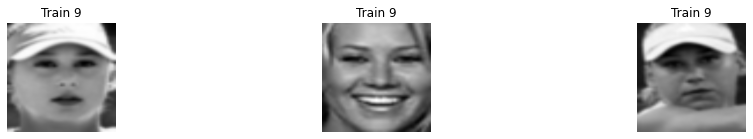

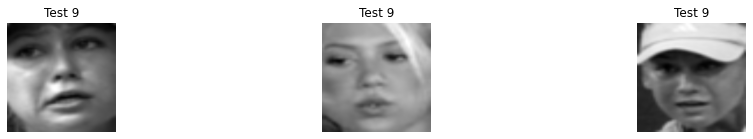

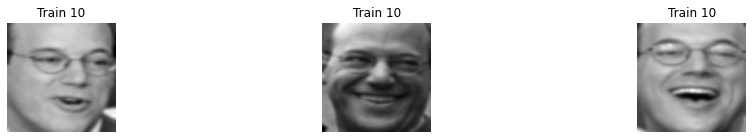

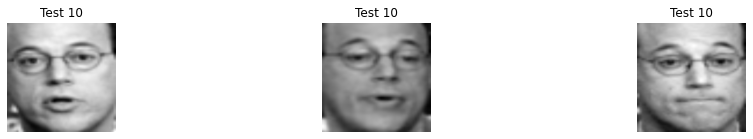

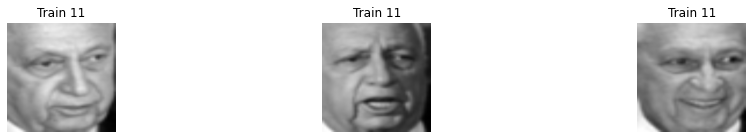

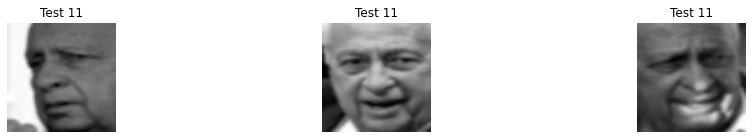

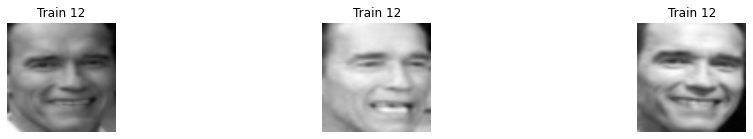

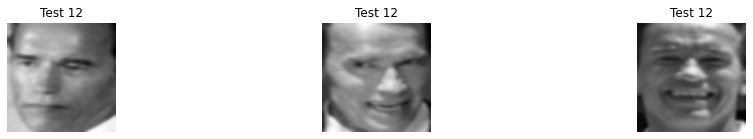

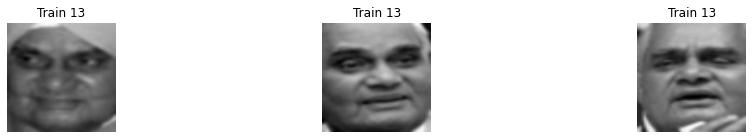

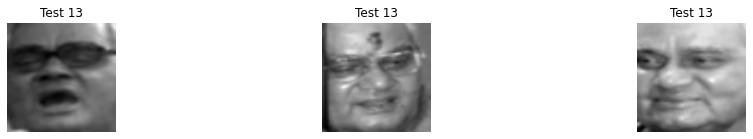

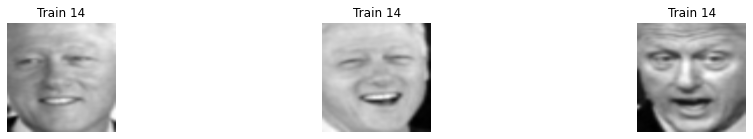

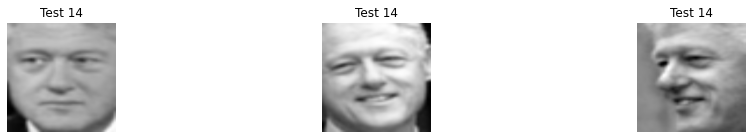

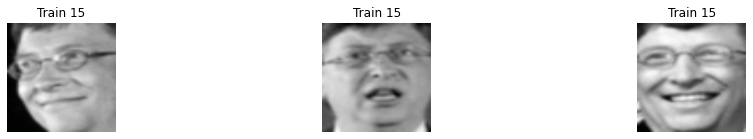

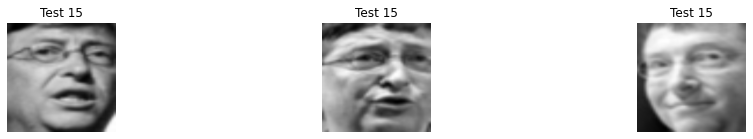

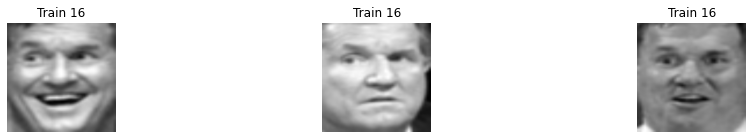

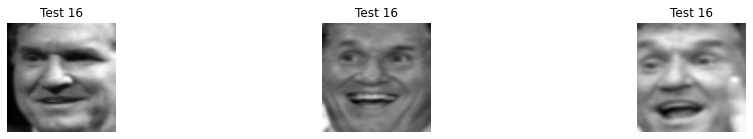

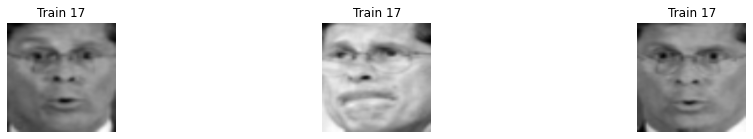

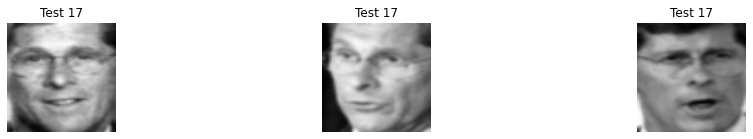

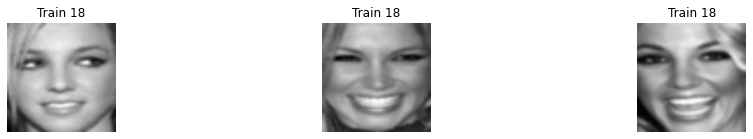

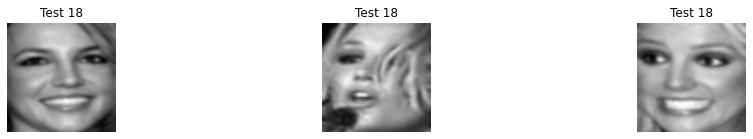

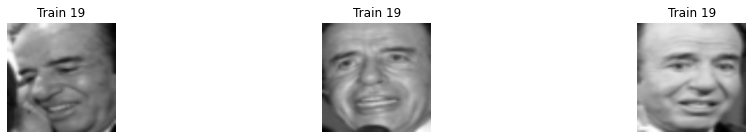

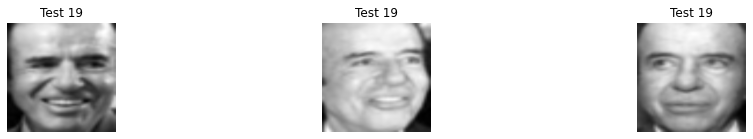

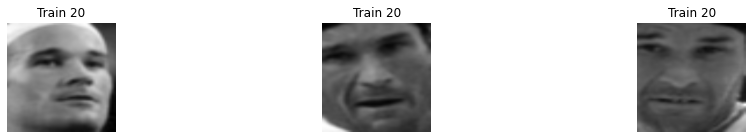

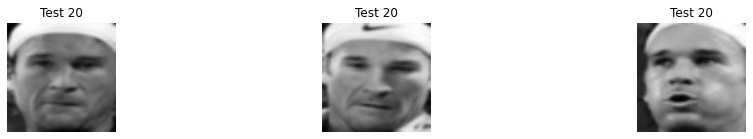

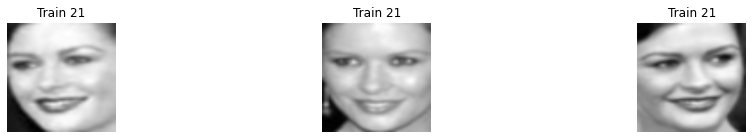

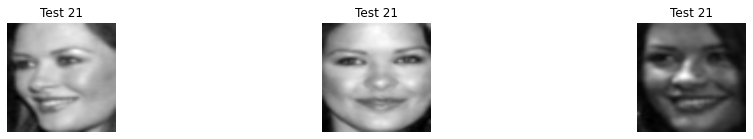

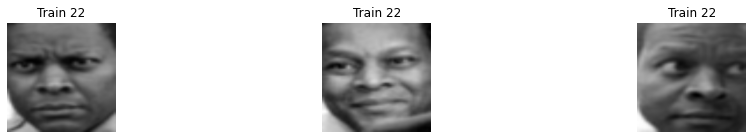

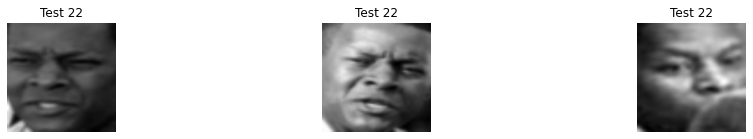

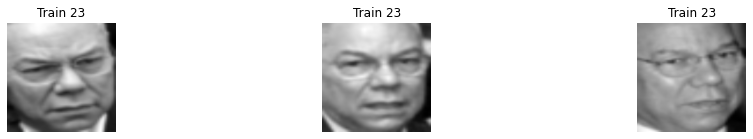

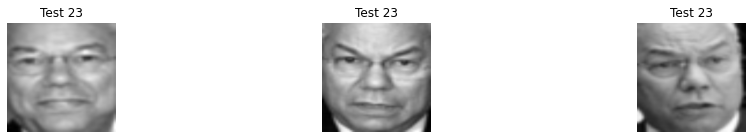

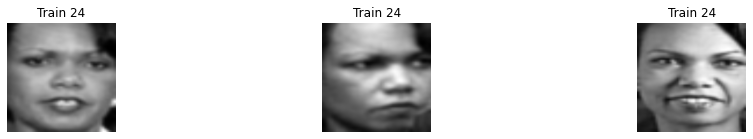

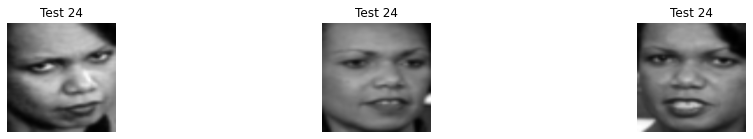

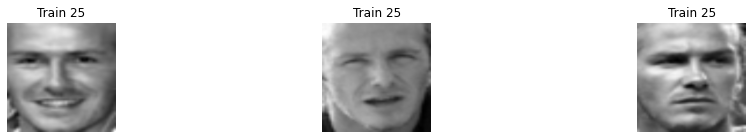

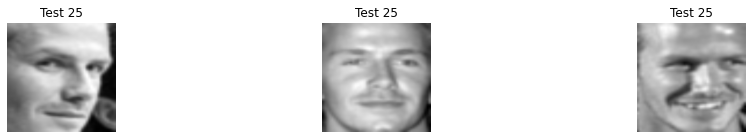

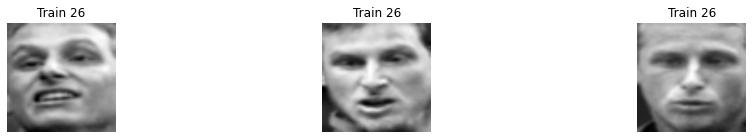

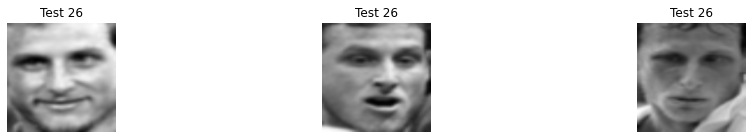

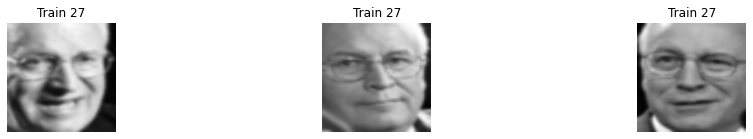

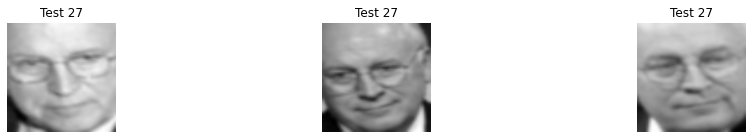

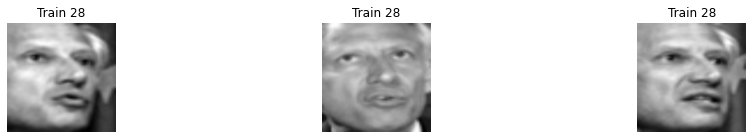

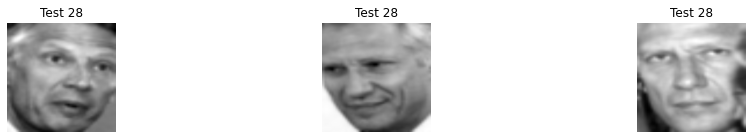

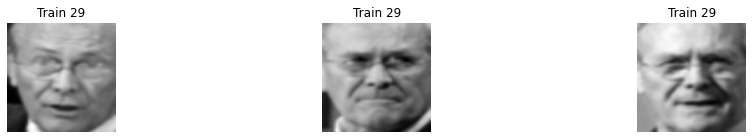

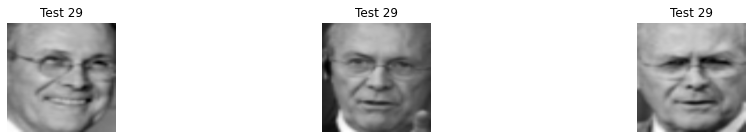

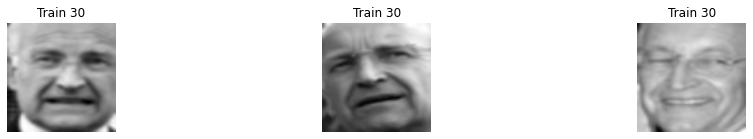

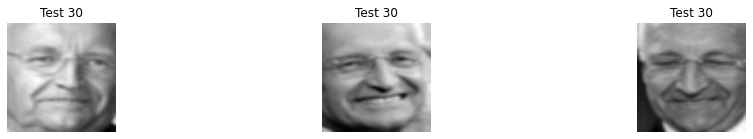

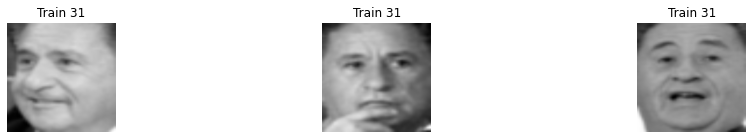

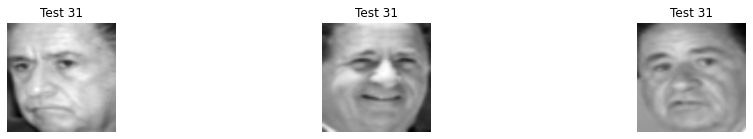

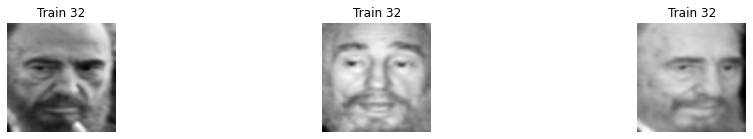

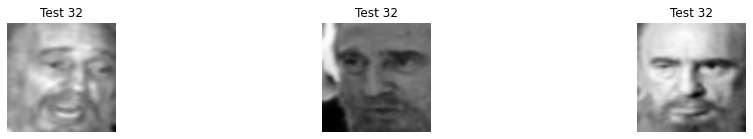

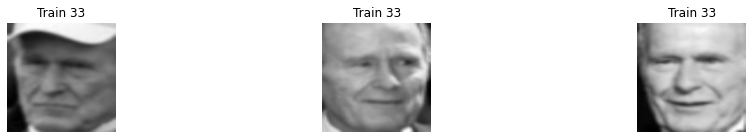

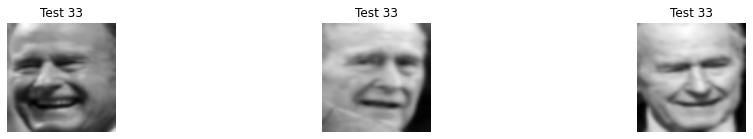

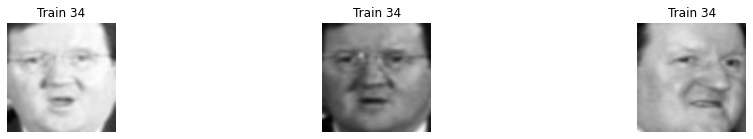

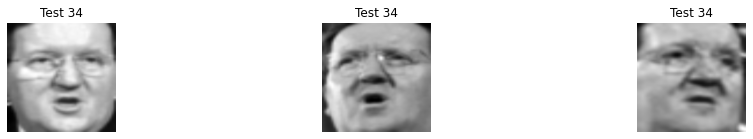

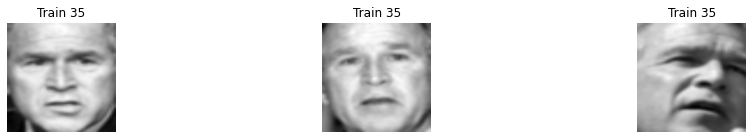

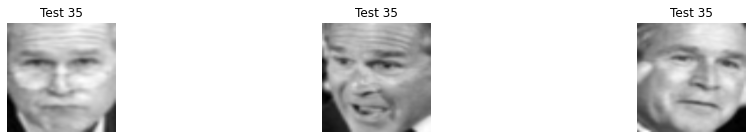

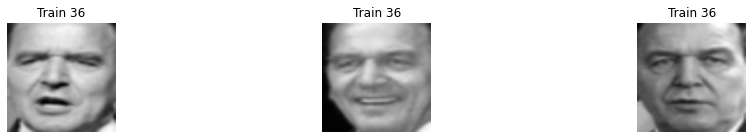

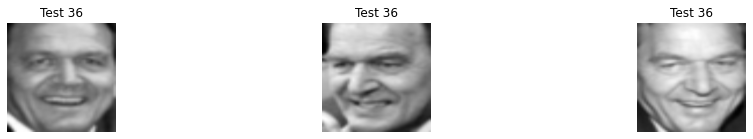

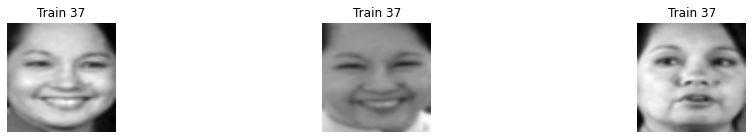

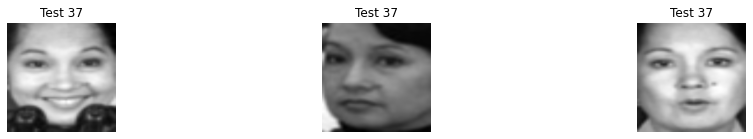

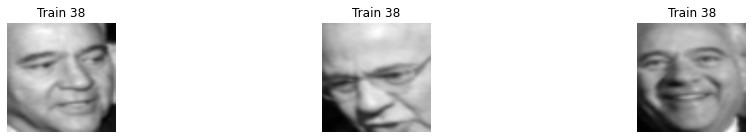

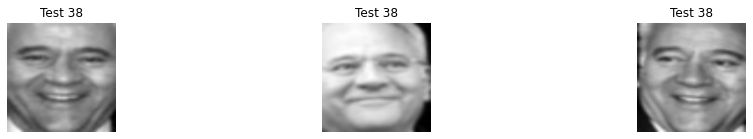

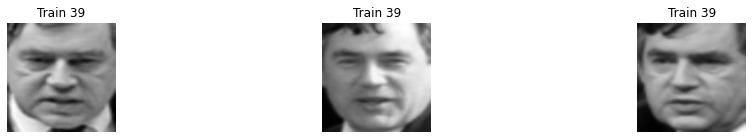

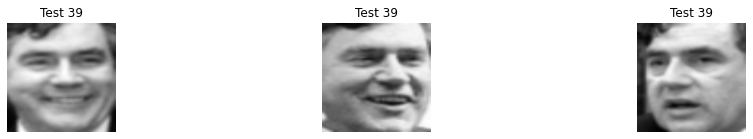

In [21]:
dataset, name_dataset = LoadDataset(0) # 0 - LFW , 1 - Olivetti
images = dataset.images
faces = dataset.data
n_samples, n_features = faces.shape
n_classes = len(Counter(dataset.target).keys())

images = resize_images_dataset(images,n_samples,IMG_SHAPE)

# Ao fazer download do banco de dados, existe uma variável target que seria o rótulo de cada imagem
dataset_train, dataset_test, x_train, x_test, y_train, y_test = fill_datasets(images, dataset.target.T, n_classes)

for i in range(40):
    DrawPics(dataset_train[i],3,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],3,template='Test {}',classnumber=i)

## **Criação e Treinamento do Modelo**

### **Triplet Loss**

O objetivo é construir "trigêmeos" <âncora, positivo, negativo> consistindo em uma imagem âncora, uma imagem positiva (que é semelhante à imagem âncora) e uma imagem negativa (que é diferente da imagem âncora). Existem diferentes maneiras de definir imagens semelhantes e diferentes. Se você tiver um conjunto de dados com vários rótulos como a classe de destino, as imagens da mesma classe poderão ser consideradas semelhantes e as imagens de diferentes classes poderão ser consideradas diferentes.

<img src="https://miro.medium.com/max/602/0*_WNBFcRVEOz6QM7R."></img>

In [22]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.cast(tf.equal(distances, 0.0), dtype=tf.float32)
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask

def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)
    return mask

def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def triplet_loss(labels, embeddings):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """

    margin = 0.5
    squared = True
    labels = labels[:,0]

    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.cast(mask, dtype=tf.float32)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.cast(tf.greater(triplet_loss, 1e-16), dtype=tf.float32)
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)
    return triplet_loss

### **Multiclass N-Pair Loss**

Para minimizar a distância entre as características de duas imagens semelhantes e forçar a separação entre as características de imagem diferentes, a função de perda de contraste codifica as medidas, semelhança e dissimilaridade, independentemente em uma função de perda. Ele aborda diretamente uma distância entre os recursos de imagem de duas imagens semelhantes, e a distância entre dois recursos de imagem diferentes é incluída na perda se eles não forem separados por uma margem de distância, α . Nesse sentido, a função de perda é definida como segue.

<img src="https://image.slidesharecdn.com/main-180928092811/95/efficient-endtoend-learning-for-quantizable-representations-15-638.jpg?cb=1538614569"></img>

In [23]:
'Inplementation in tensorflow by: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/losses/python/metric_learning/metric_loss_ops.py'

def npairs_loss(labels, embeddings):
    batch_size = len(embeddings)
    reg_lambda=0.002
    labels = labels[:batch_size//2, 0]
    embeddings_anchor = embeddings[:batch_size // 2, :]
    embeddings_positive = embeddings[batch_size // 2:batch_size, :]

    # pylint: enable=line-too-long
    # Add the regularizer on the embedding.
    reg_anchor = tf.reduce_mean(tf.reduce_sum(tf.square(embeddings_anchor), 1))
    reg_positive = tf.reduce_mean(tf.reduce_sum(tf.square(embeddings_positive), 1))
    l2loss = tf.multiply(0.25 * reg_lambda, reg_anchor + reg_positive, name='l2loss')

    # Get per pair similarities.
    similarity_matrix = tf.linalg.matmul(embeddings_anchor, embeddings_positive, transpose_a=False, transpose_b=True)

    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    lshape = tf.shape(labels)
    assert lshape.shape == 1
    labels = tf.reshape(labels, [lshape[0], 1])

    labels_remapped = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    labels_remapped /= tf.reduce_sum(labels_remapped, 1, keepdims=True)

    # Add the softmax loss.
    xent_loss = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=similarity_matrix, labels=labels_remapped)
    xent_loss = tf.reduce_mean(xent_loss, name='xentropy')

    return l2loss + xent_loss

### **Constelation Loss**

O Constelation Loss leva o melhor do Triplet Loss e multiclass-N-pair loss. Usa a mesma construção de lote que o Triplet Loss e uma formulação de perda semelhante ao multiclass-N-pair loss. O hiperparâmetro K define o número de trigêmeos que queremos incorporar na fórmula, desta forma, tomando
em conta termos mais negativos do que o Triplet Loss usual. Mesmo que aumentar o parâmetro K significa um esforço computacional maior, em algum ponto o fato de aumentar K não afeta muito o resultado. Isso se deve à aleatoriedade na escolha de cada termo, que pode ser composto de vários valores negativos distintos. Portanto, não há necessidade de um alto valor K
para melhorar os resultados do Triplet Loss ou multiclass-N-pair loss. A principal diferença é que multiclass-N-pair-loss subtrai produtos escalares de pares de mesma classe, enquanto o Constelation Loss faz algo semelhante ao Triplet Loss, operando com a subtração de um produto escalar de uma âncora e incorporação negativa; e um produto escalar de um âncora e incorporação positiva.

<img src="https://i.ibb.co/p4VNF9b/Constellation-Loss.png" alt="Constellation-Loss" border="0"></img>

In [24]:
def constellation_loss(k, BATCH_SIZE):

    def c_loss(labels, embeddings):
        """Build the constellation loss over a batch of embeddings.
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)

        Returns:
            ctl_loss: scalar tensor containing the constellation loss
        """
        labels = labels[:, 0]

        labels_list = []
        embeddings_list = []
        for i in range(k):
            labels_list.append(labels[BATCH_SIZE * i:BATCH_SIZE * (i + 1)])
            embeddings_list.append(embeddings[BATCH_SIZE * i:BATCH_SIZE * (i + 1)])

        loss_list = []
        for i in range(len(embeddings_list)):
            # Get the dot product
            pairwise_dist = tf.matmul(embeddings_list[i], tf.transpose(embeddings_list[i]))

            # shape (batch_size, batch_size, 1)
            anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
            assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
            # shape (batch_size, 1, batch_size)
            anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
            assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)
            ctl_loss = anchor_negative_dist - anchor_positive_dist

            # (where label(a) != label(p) or label(n) == label(a) or a == p)
            mask = _get_triplet_mask(labels_list[i])
            mask = tf.cast(mask, dtype='float32')
            ctl_loss = tf.multiply(mask, ctl_loss)

            loss_list.append(ctl_loss)

        ctl_loss = 1. + tf.exp(loss_list[0])

        for i in range(1, len(embeddings_list)):
            ctl_loss += tf.exp(loss_list[i])

        ctl_loss = tf.math.log(ctl_loss)

        # # Get final mean constellation loss and divide due to very large loss value
        ctl_loss = tf.reduce_sum(ctl_loss) / 1000.

        return ctl_loss

    return c_loss

### **Função de otimização e perda**

O algoritmo de Adam para otimizar o processo de treinamento, mesmo com uma taxa de aprendizado pequena de 0,00006, gerou uma diminuição na perda de validação muito mais rápida em comparação com a simples descida de gradiente estocástico.

Para a função de perda, utiliza-se a função de triplet loss definida anteriormente.

In [25]:
optimizer = Adam(lr = 0.00006)

### **Criação do Modelo**

In [26]:
def build_network(input_shape, backbone, embeddingsize, loss_type):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    #model = applications.InceptionResNetV2(input_shape=input_shape, include_top=False)
    #new_output = keras.layers.Dropout(0.2)(model.output)
    #new_output = keras.layers.Flatten()(new_output)
    #new_output = keras.layers.Dense(4096, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(new_output)
    #new_output = keras.layers.Dense(embeddingsize, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(new_output)
    #new_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(new_output)

    #network = keras.engine.training.Model(model.inputs, new_output)
    
    if backbone == "inception_resnet":
        model = applications.InceptionResNetV2(include_top=False, input_shape=(224, 224, 3))
                    
    elif backbone == "resnet":
        model = applications.ResNet152V2(include_top=False, input_shape=(224, 224, 3))

    else:
        model = applications.InceptionV3(include_top=False, input_shape=(224, 224, 3))
        
    # add global pooling just like in InceptionV3
    new_output = GlobalAveragePooling2D()(model.output)
    
    # # add new dense layer for our labels
    new_output = Dense(embeddingsize,activation='sigmoid')(new_output)
    if loss_type != "n_pairs":
        new_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(new_output)
    
    model = Model(model.inputs, new_output)
    
    #trainable = False
    #    for layer in model.layers:
    #        if layer.name == "latent_space":
    #            trainable = True
    #        layer.trainable = trainable
    for layer in model.layers:
        if isinstance(layer, BatchNormalization):
            layer.momentum = 0.9
    
        for layer in model.layers[:-50]:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False
                    
    if loss_type == "triplet":
        model.compile(loss=triplet_loss,optimizer=optimizer)
    elif loss_type == "constellation":
        model.compile(loss=constellation_loss(k, BATCH_SIZE),optimizer=optimizer)
    elif loss_type == "n_pairs":
        model.compile(loss=npairs_loss,optimizer=optimizer)
    #network = Sequential([model,
    #                      Dropout(0.2),
    #                      Flatten(),
    #                      Dense(4096, activation='relu',
    #                            kernel_regularizer=l2(1e-3),
    #                            kernel_initializer='he_uniform'),
    #                      Dense(embeddingsize, activation=None,
    #                            kernel_regularizer=l2(1e-3),
    #                            kernel_initializer='he_uniform'),
    #                      Lambda(lambda x: K.l2_normalize(x,axis=-1))
    #])
    
    return model

In [35]:
BATCH_SIZE = 8
k = 6
backbone = "resnet" #inception, resnet, inception_resnet
loss_type = "triplet" #constellation, triplet, n_pairs
emb_size = 128
network = build_network(IMG_SHAPE, backbone, emb_size, loss_type)
#network.summary()
#plot_model(network,show_shapes=True, show_layer_names=True, to_file='model.png')
#network.load_weights("D:/Documentos/Documentos - Erick/UFES/Mestrado/Projeto de Mestrado/Weights/" + backbone + "/" + name_dataset + "/" + loss_type + "_loss_" + str(k) + ".h5")

### **Preparação dos lotes para treinamento**

In [28]:
def data_augmentation(img):

    a =  random.randint(0,1)
    b = random.randint(0,3)

    image_a = [img, img[::-1,:,:]]
    angle_a = [0,90,180,270]

    image_transformed = skimage.transform.rotate(image_a[a],angle=angle_a[b])
    return preprocess_input(image_transformed)

def preprocess_input(x):
    x -= 0.5
    x *= 2.
    return x

In [29]:
import skimage.transform
import random

def generator_constellation(x, y, k, BATCH_SIZE):
    n_img = 0
    while True:
        x_in = []
        y_in= []
        for n in range(BATCH_SIZE*k):

            if n_img >= len(x):
                x, y = shuffle(x, y)
                n_img = 0
                
            #image_augmented = data_augmentation(x[n_img])
            #x_in.append(image_augmented)
            
            x_in.append(x[n_img])
            y_in.append(y[n_img])

            n_img  += 1

        x_in, y_in = np.asarray(x_in), np.asarray(y_in)
        yield x_in, y_in

def generator_n_pairs(x, y):
    x_class = [[] for i in range(len(np.unique(y)))]
    for i in range(len(x)):
        x_class[y[i]].append(x[i])

    ind = [0 for i in range(len(np.unique(y)))]
    y_class = [i for i in range(len(np.unique(y)))]

    while True:
        x_in = []
        y_in= []

        x_class, ind, y_class = shuffle(x_class, ind, y_class)

        for n in range(2):

            for i in range(len(ind)):
                if ind[i] >= len(x_class[i]):
                    x_class[i] = shuffle(x_class[i])
                    ind[i] = 0

            for i in range(len(ind)):
                x_in.append(x_class[i][ind[i]])
                y_in.append(y_class[i])

                ind[i] += 1

        x_in, y_in = np.asarray(x_in), np.asarray(y_in)

        yield x_in, y_in

        
def generator_triplet(x, y, BATCH_SIZE):
    n_img = 0
    while True:
        x_in = []
        y_in= []
        for n in range(BATCH_SIZE):

            if n_img >= len(x):
                x, y = shuffle(x, y)
                n_img = 0

            x_in.append(x[n_img])
            y_in.append(y[n_img])

            n_img  += 1

        x_in, y_in = np.asarray(x_in), np.asarray(y_in)
        yield x_in, y_in


### **Hiperparâmetros**

In [30]:
# Hyper parameters
EPOCHS = 100

### **Treinamento**

In [31]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")

Starting training process!
-------------------------------------
Epoch 1/100
379/379 [==============================] - 96s 253ms/step - loss: 0.2115 - val_loss: 0.1881
Epoch 2/100
379/379 [==============================] - 94s 249ms/step - loss: 0.1800 - val_loss: 0.1511
Epoch 3/100
379/379 [==============================] - 95s 250ms/step - loss: 0.1534 - val_loss: 0.1168
Epoch 4/100
379/379 [==============================] - 96s 253ms/step - loss: 0.1422 - val_loss: 0.1497
Epoch 5/100
379/379 [==============================] - 96s 254ms/step - loss: 0.1255 - val_loss: 0.1857
Epoch 6/100
379/379 [==============================] - 97s 255ms/step - loss: 0.1222 - val_loss: 0.1454
Epoch 7/100
379/379 [==============================] - 97s 256ms/step - loss: 0.1138 - val_loss: 0.1222
Epoch 8/100
379/379 [==============================] - 97s 257ms/step - loss: 0.1018 - val_loss: 0.1351
Epoch 9/100
379/379 [==============================] - 97s 257ms/step - loss: 0.1021 - val_loss: 0.1267

379/379 [==============================] - 99s 260ms/step - loss: 0.0292 - val_loss: 0.0541
Epoch 77/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0315 - val_loss: 0.0728
Epoch 78/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0288 - val_loss: 0.0447
Epoch 79/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0333 - val_loss: 0.0457
Epoch 80/100
379/379 [==============================] - 99s 261ms/step - loss: 0.0363 - val_loss: 0.0559
Epoch 81/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0276 - val_loss: 0.0523
Epoch 82/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0331 - val_loss: 0.0653
Epoch 83/100
379/379 [==============================] - 99s 261ms/step - loss: 0.0323 - val_loss: 0.0414
Epoch 84/100
379/379 [==============================] - 99s 260ms/step - loss: 0.0311 - val_loss: 0.0665
Epoch 85/100
379/379 [==============================] - 99s 260ms/st

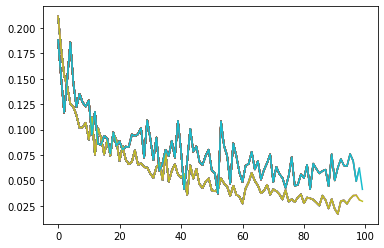

In [36]:
BATCH_SIZE_TRAIN = BATCH_SIZE
if loss_type == "constellation":
    generator_train = generator_constellation(x_train, y_train, k, BATCH_SIZE)
    generator_test = generator_constellation(x_test, y_test, k, BATCH_SIZE)
elif loss_type == "n_pairs":
    generator_train = generator_n_pairs(x_train, y_train)
    generator_test = generator_n_pairs(x_test, y_test)
    BATCH_SIZE_TRAIN = len(np.unique(y_train))
elif loss_type == "triplet":
    generator_train = generator_triplet(x_train, y_train, BATCH_SIZE)
    generator_test = generator_triplet(x_test, y_test, BATCH_SIZE)

steps_train = int(len(x_train) * 1. / BATCH_SIZE_TRAIN) + 1
steps_test = int(len(x_test) * 1. / BATCH_SIZE_TRAIN) + 1

# TRAIN
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
loss_plot = PlotLosses()    
    
network.fit(generator_train, batch_size=BATCH_SIZE_TRAIN, steps_per_epoch=steps_train,
            validation_data=generator_test, validation_steps=steps_test,
            epochs=EPOCHS, callbacks=[loss_plot])

print("--- %s seconds ---" % (time.time() - t_start))

### **Salvando os Pesos**

In [62]:
if loss_type == "constellation":
    network.save_weights("D:/Documentos/Documentos - Erick/UFES/Mestrado/Projeto de Mestrado/Weights_Augmentation/" + backbone + "/" + name_dataset + "/" + loss_type + "_" + str(k) + ".h5")
else:
    network.save_weights("D:/Documentos/Documentos - Erick/UFES/Mestrado/Projeto de Mestrado/Weights_Augmentation/" + backbone + "/" + name_dataset + "/" + loss_type + ".h5")

## **Avaliação**

### **Curva ROC**

A curva é construída da seguinte maneira: com o valor de To encontra-se o valor do FRR e do FAR, pelas curvas 1 e 2, respectivamente. No eixo X é colocado o valor do FAR e no eixo Y é colocado o valor 1 (um) menos o FRR. Este procedimento é repetido para todos os valores de To gerando a curva ROC.

*  Curva 1 (FRR: Taxa de falsa rejeição):

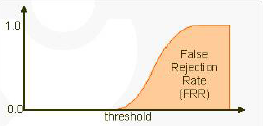

* Curva 2 (FAR: Taxa de falsa aceitação):

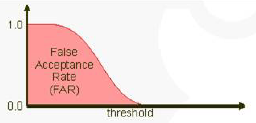


In [63]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
    
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
        #Against all other images
        for j in range(i+1,m):
            #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
            probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
            if (Y[i]==Y[j]):
                y[k] = 1
                #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
            else:
                y[k] = 0
                #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
            k += 1
    return probs,y

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances 
                    being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensibilidade : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

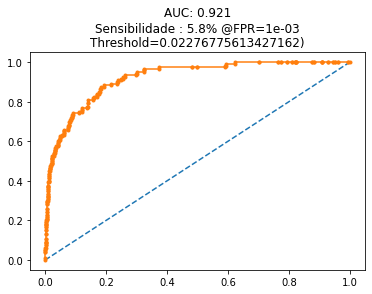

In [64]:
probs,yprob = compute_probs(network,x_test,y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)

### **Distâncias Interclasse**

Outra métrica interessante a ser observada durante o treinamento é o quão "distantes" estão os embeddings de cada classe. Para ser completo, devemos avaliar todo o conjunto de dados, mas aqui é apenas para verificar se a rede está convergindo suavemente para todas as classes.

In [65]:
def compute_interdist(network, input_shape):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((n_classes,n_classes))
    img_rows = input_shape[0]
    img_cols = input_shape[1]
    img_layers = input_shape[2]
    ref_images = np.zeros((n_classes,img_rows,img_cols,img_layers))
    
    #generates embeddings for reference images
    for i in range(n_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(n_classes):
        for j in range(n_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration,input_shape):
    interdist = compute_interdist(network, input_shape)
    
    data = []
    for i in range(n_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(n_classes))

    plt.show()

def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N = 4
    _, w,h,c = dataset_test[0].shape
    n_images = images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((n_classes,w,h,c))
    for i in range(n_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(n_images):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,5+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,:],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(5):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,5+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,:],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

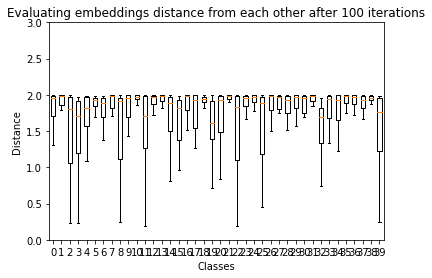

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

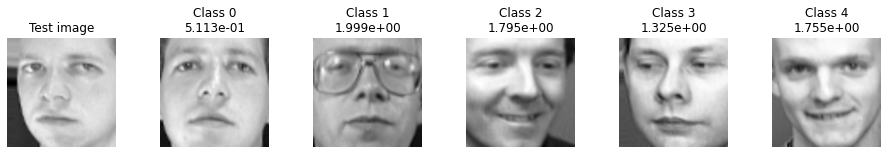

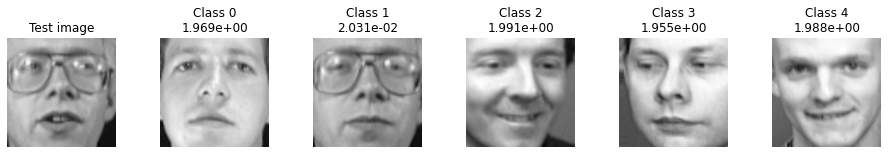

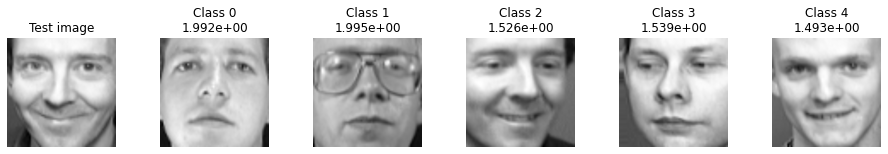

In [66]:
draw_interdist(network, EPOCHS, IMG_SHAPE)
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

In [67]:
dataset, name_dataset = LoadDataset(1) # 0 - LFW , 1 - Olivetti
images = dataset.images
faces = dataset.data
n_samples, n_features = faces.shape
n_classes = len(Counter(dataset.target).keys())

images = resize_images_dataset(images,n_samples,IMG_SHAPE)

# Ao fazer download do banco de dados, existe uma variável target que seria o rótulo de cada imagem
dataset_train, dataset_test, x_train, x_test, y_train, y_test = fill_datasets(images, dataset.target.T, n_classes)

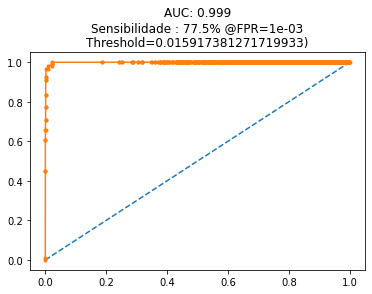

In [68]:
emb_size = 128
BATCH_SIZE = 8
k = 6
backbone = "inception" #inception, resnet, inception_resnet
loss_type = "constellation" #constellation, triplet, n_pairs
network = build_network(IMG_SHAPE, backbone, emb_size, loss_type)
if loss_type == "constellation":
    network.load_weights("D:/Documentos/Documentos - Erick/UFES/Mestrado/Projeto de Mestrado/Weights/" + backbone + "/" + name_dataset + "/" + loss_type + "_" + str(k) + ".h5")
else:
    network.load_weights("D:/Documentos/Documentos - Erick/UFES/Mestrado/Projeto de Mestrado/Weights/" + backbone + "/" + name_dataset + "/" + loss_type + ".h5")
    
probs,yprob = compute_probs(network,x_test,y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

index_embeddings=network.predict(x_train)
knn=KNeighborsClassifier(2)
#y_knn=np.arange(index_embeddings.shape[0])
knn.fit(index_embeddings,y_train)
query_embeddings=network.predict(x_test)
preds=knn.predict(query_embeddings)

print('Acurácia:', accuracy_score(y_test, preds))
print('F-Measure:', f1_score(y_test, preds, average='weighted'))

Acurácia: 0.95
F-Measure: 0.9513690476190476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

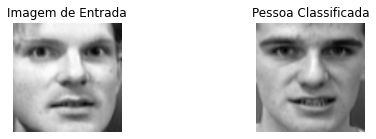

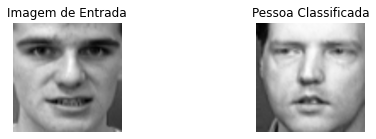

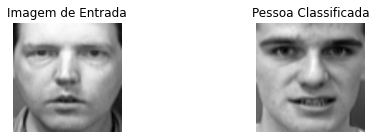

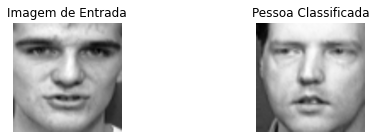

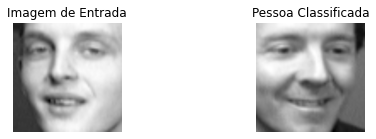

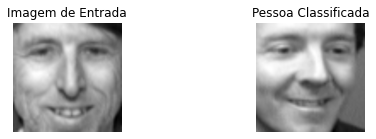

In [70]:
valores_distintos = [i for i, (x, y) in enumerate(zip(y_test, preds)) if x != y]

for i in valores_distintos:
    fig=plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,2,1)
    axis("off") 
    plt.imshow(x_test[i,:,:,:],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text("Imagem de Entrada")
    subplot = fig.add_subplot(1,2,2)
    axis("off")
    #DrawPics(dataset_test[preds[57]],1,template='Train {}',classnumber=preds[57])
    plt.imshow(dataset_test[preds[i]][0,:,:,:],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text("Pessoa Classificada")

In [71]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

def scatter(x, labels, qnt_labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", qnt_labels))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    #txts = []
    #for i in range(qnt_labels):
    #    # Position of each label.
    #    xtext, ytext = np.median(x[labels == i, :], axis=0)
    #    txt = ax.text(xtext, ytext, str(i), fontsize=10)
    #    txt.set_path_effects([
    #        PathEffects.Stroke(linewidth=3, foreground="w"),
    #        PathEffects.Normal()])
    #    txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
    
tsne = TSNE()

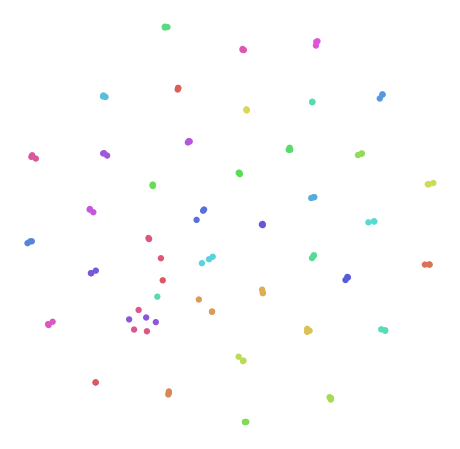

In [72]:
dados_trm = network.predict(x_test)
dados_tsne_embeds = tsne.fit_transform(dados_trm)
scatter(dados_tsne_embeds, y_test, len(np.unique(y_test)), "")